# TNT Single-Mode: Small-Amplitude Oscillatory Shear

## Learning Objectives
1. Understand SAOS response of transient network materials
2. Fit TNT single-mode model to frequency-dependent moduli
3. Extract storage (G') and loss (G'') moduli from model
4. Analyze crossover frequency ω_c = 1/τ_b
5. Generate Cole-Cole plot and tan(δ) analysis
6. Perform Bayesian inference for parameter uncertainty

## Prerequisites
- Understanding of transient network theory (Notebook 01)
- Familiarity with linear viscoelasticity
- Knowledge of SAOS fundamentals (G', G'', tan(δ))

## Runtime Estimate
- NLSQ fitting: ~2-5 seconds
- Bayesian inference (demo): ~30-60 seconds
- Total: ~2-3 minutes

## 1. Setup

In [1]:
import os
import sys
import time

# Google Colab support
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTSingleMode

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_epstein_saos,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_single_mode_param_names,
)

## 2. Theory

## SAOS Response of Transient Networks

### Physical Mechanism

In Small-Amplitude Oscillatory Shear (SAOS):
1. **Sinusoidal strain** γ(t) = γ₀ sin(ωt) is applied
2. **Stress response** σ(t) = γ₀[G'(ω) sin(ωt) + G''(ω) cos(ωt)]
3. **Storage modulus G'**: Energy stored (elastic response)
4. **Loss modulus G''**: Energy dissipated (viscous response)

### Governing Equations

For a Maxwell-like transient network:

$$
G'(\omega) = \frac{G (\omega \tau_b)^2}{1 + (\omega \tau_b)^2}
$$

$$
G''(\omega) = \frac{G (\omega \tau_b)}{1 + (\omega \tau_b)^2} + \eta_s \omega
$$

### Frequency Regimes

1. **Low frequency (ω ≪ 1/τ_b)**:
   - Terminal regime: G' ~ ω², G'' ~ ω
   - Viscous behavior dominates

2. **High frequency (ω ≫ 1/τ_b)**:
   - Plateau regime: G' → G, G'' → η_s·ω
   - Elastic behavior dominates

### Crossover Frequency

The crossover frequency ω_c where G' = G'' is:

$$
\omega_c \approx \frac{1}{\tau_b}
$$

This provides a direct measure of the **relaxation time**.

### Loss Tangent

The loss tangent quantifies viscoelastic character:

$$
\tan(\delta) = \frac{G''(\omega)}{G'(\omega)}
$$

- tan(δ) ≫ 1: Viscous liquid
- tan(δ) ≈ 1: Viscoelastic
- tan(δ) ≪ 1: Elastic solid

### Material Analogy: Metal-Organic Coordination Networks

**Metal-organic coordination polymers** are an **EXCELLENT target** for TNT models:
- Metal-ligand bonds act as reversible transient crosslinks
- Bond lifetime τ_b = 1/k_off (dissociation rate)
- This dataset from Epstein et al. is an ideal match!

### Parameters

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| Elastic modulus | $G$ | Plateau modulus | 1-10000 Pa |
| Breakage time | $\tau_b$ | Relaxation time | 0.001-10 s |
| Solvent viscosity | $\eta_s$ | Background viscosity | 0.001-1 Pa·s |

## 3. Load Data

In [2]:
# Load SAOS data (metal-organic coordination polymer)
omega, G_prime, G_double_prime = load_epstein_saos()

print(f"Data shape: {len(omega)} points")
print(f"Frequency range: {omega.min():.3f} - {omega.max():.3f} rad/s")
print(f"G' range: {G_prime.min():.2f} - {G_prime.max():.2f} Pa")
print(f"G'' range: {G_double_prime.min():.2f} - {G_double_prime.max():.2f} Pa")
print(f"\nMaterial: Metal-organic coordination network (Ni-histidine)")
print(f"Note: Metal-ligand bonds = reversible transient crosslinks")
print(f"      This is an EXCELLENT target for TNT models!")

Data shape: 19 points
Frequency range: 0.101 - 99.419 rad/s
G' range: 8.28 - 2930.48 Pa
G'' range: 27.80 - 2216.50 Pa

Material: Metal-organic coordination network (Ni-histidine)
Note: Metal-ligand bonds = reversible transient crosslinks
      This is an EXCELLENT target for TNT models!


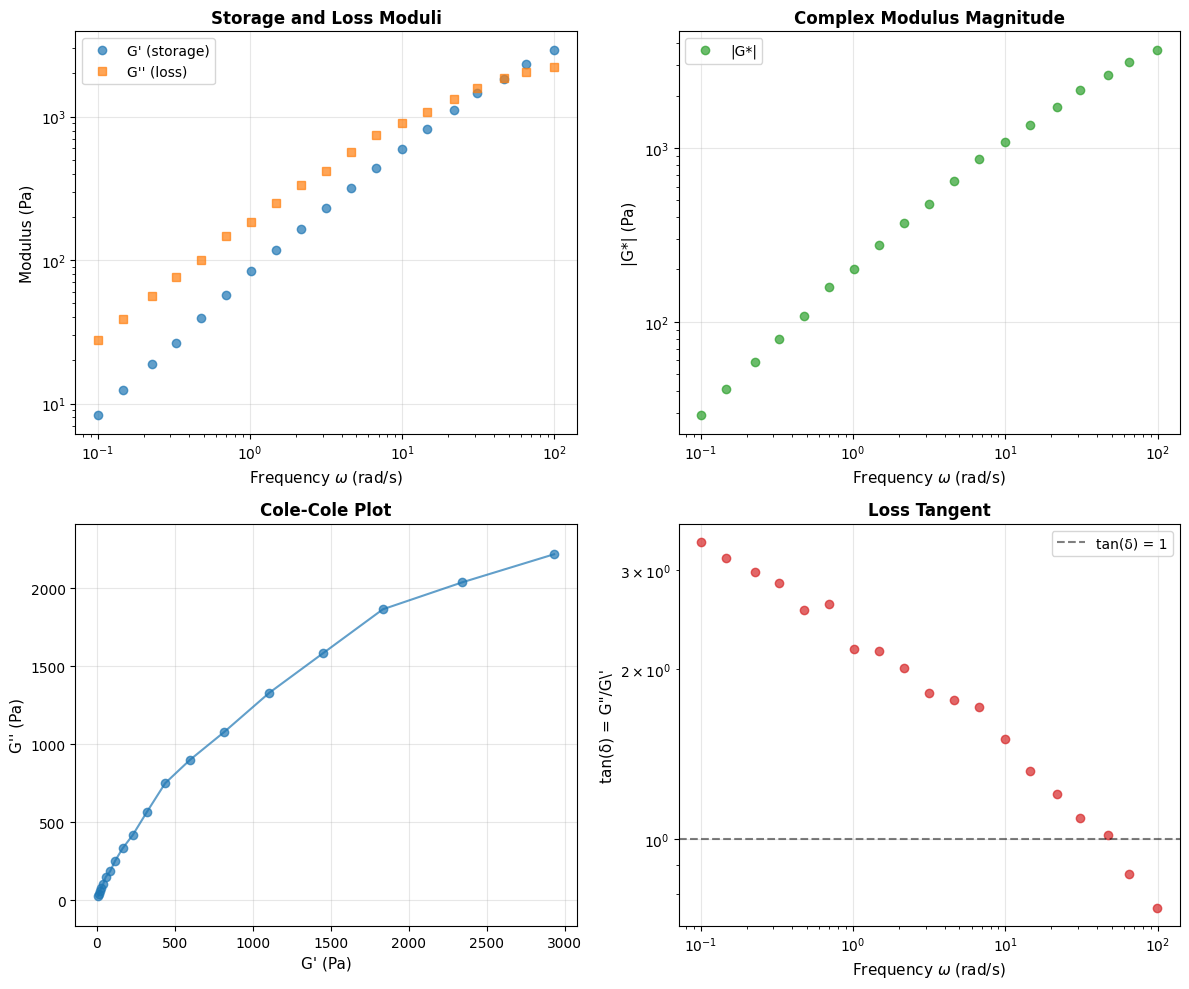


Crossover frequency: ω_c ≈ 0.101 rad/s
Estimated relaxation time: τ_b ≈ 1/ω_c ≈ 9.922 s


In [3]:
# Plot raw data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. G', G'' vs frequency
ax = axes[0, 0]
ax.loglog(omega, G_prime, 'o', label="G' (storage)", markersize=6, alpha=0.7)
ax.loglog(omega, G_double_prime, 's', label="G'' (loss)", markersize=6, alpha=0.7)
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=11)
ax.set_ylabel('Modulus (Pa)', fontsize=11)
ax.set_title('Storage and Loss Moduli', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Complex modulus magnitude
ax = axes[0, 1]
G_star_mag = np.sqrt(G_prime**2 + G_double_prime**2)
ax.loglog(omega, G_star_mag, 'o', label='|G*|', markersize=6, alpha=0.7, color='C2')
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=11)
ax.set_ylabel(r'|G*| (Pa)', fontsize=11)
ax.set_title('Complex Modulus Magnitude', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Cole-Cole plot
ax = axes[1, 0]
ax.plot(G_prime, G_double_prime, 'o-', markersize=6, alpha=0.7)
ax.set_xlabel("G' (Pa)", fontsize=11)
ax.set_ylabel("G'' (Pa)", fontsize=11)
ax.set_title('Cole-Cole Plot', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# 4. Loss tangent
ax = axes[1, 1]
tan_delta = G_double_prime / G_prime
ax.loglog(omega, tan_delta, 'o', markersize=6, alpha=0.7, color='C3')
ax.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='tan(δ) = 1')
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=11)
ax.set_ylabel(r'tan(δ) = G"/G\'', fontsize=11)
ax.set_title('Loss Tangent', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find crossover frequency
crossover_idx = np.argmin(np.abs(G_prime - G_double_prime))
omega_c = omega[crossover_idx]
print(f"\nCrossover frequency: ω_c ≈ {omega_c:.3f} rad/s")
print(f"Estimated relaxation time: τ_b ≈ 1/ω_c ≈ {1/omega_c:.3f} s")

## 4. NLSQ Fitting

In [4]:
# Compute complex modulus magnitude for fitting
G_star_mag = np.sqrt(G_prime**2 + G_double_prime**2)

# Create model and fit
model = TNTSingleMode(breakage="constant")

start_time = time.time()
result = model.fit(omega, G_star_mag, test_mode="oscillation", method='scipy')
fit_time = time.time() - start_time

print(f"\nNLSQ fitting completed in {fit_time:.2f} seconds")
print(f"\nFitted Parameters:")
param_names = get_tnt_single_mode_param_names(breakage="constant")
for name in param_names:
    param = model.parameters.get(name)
    print(f"  {name} = {param.value:.4e}")


NLSQ fitting completed in 0.46 seconds

Fitted Parameters:
  G = 8.5836e+02
  tau_b = 2.0359e-01
  eta_s = 4.4226e+01


In [5]:
# Compute fit quality metrics
metrics = compute_fit_quality(G_star_mag, model.predict(omega, test_mode="oscillation"))
print(f"\nFit Quality (|G*|):")
print(f"  R² = {metrics['R2']:.6f}")
print(f"  RMSE = {metrics['RMSE']:.4e} Pa")
print(f"  NRMSE = {metrics['NRMSE']*100:.2f}%")


Fit Quality (|G*|):
  R² = 0.950998
  RMSE = 2.4479e+02 Pa
  NRMSE = 6.72%


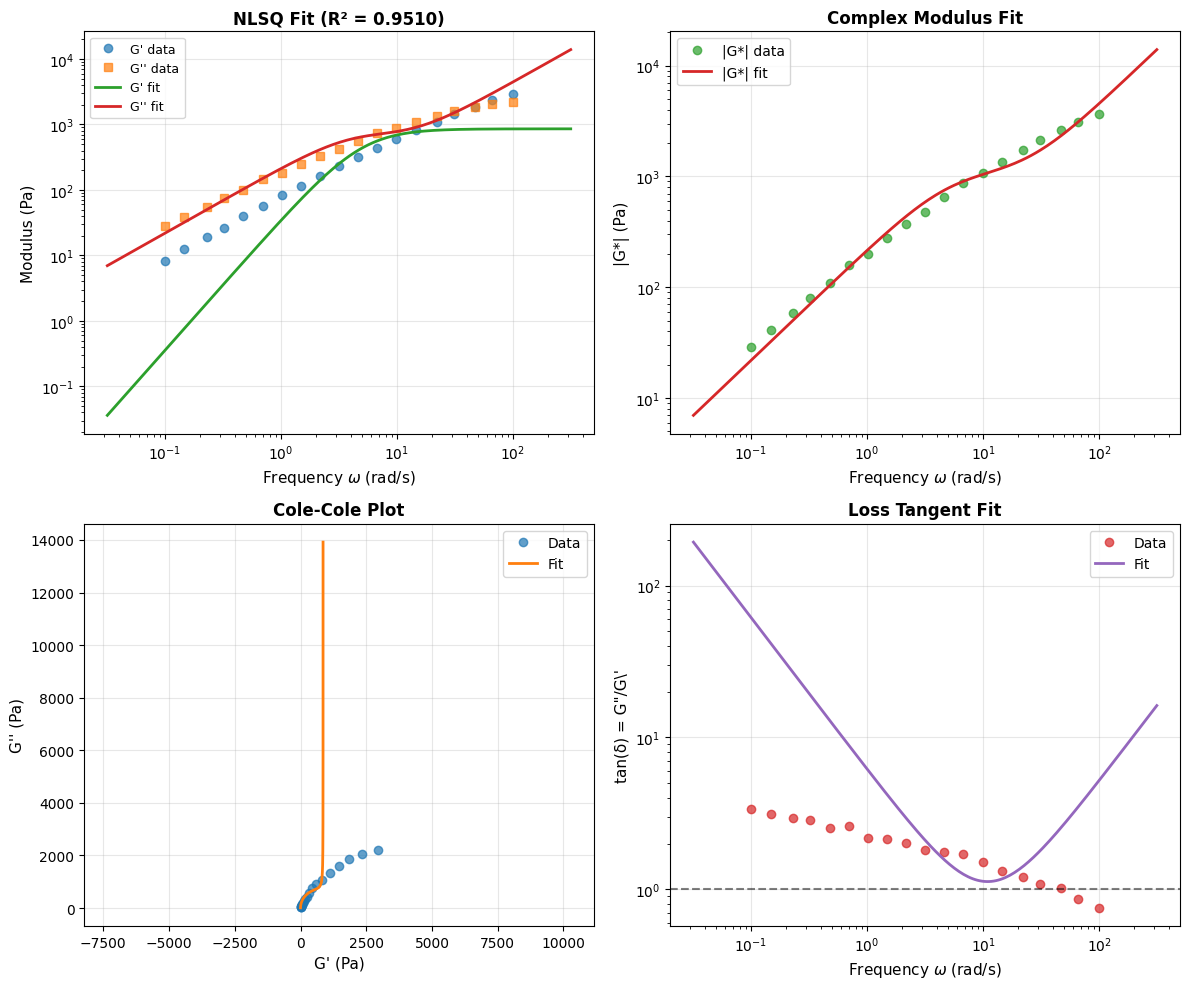

In [6]:
# Plot fit overlay
omega_fine = np.logspace(np.log10(omega.min())-0.5, np.log10(omega.max())+0.5, 200)
G_prime_pred, G_double_prime_pred = model.predict_saos(omega_fine)
G_star_mag_pred = np.sqrt(G_prime_pred**2 + G_double_prime_pred**2)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. G', G'' fit
ax = axes[0, 0]
ax.loglog(omega, G_prime, 'o', label="G' data", markersize=6, alpha=0.7)
ax.loglog(omega, G_double_prime, 's', label="G'' data", markersize=6, alpha=0.7)
ax.loglog(omega_fine, G_prime_pred, '-', label="G' fit", linewidth=2)
ax.loglog(omega_fine, G_double_prime_pred, '-', label="G'' fit", linewidth=2)
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=11)
ax.set_ylabel('Modulus (Pa)', fontsize=11)
ax.set_title(f"NLSQ Fit (R² = {metrics["R2"]:.4f})", fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 2. Complex modulus magnitude
ax = axes[0, 1]
ax.loglog(omega, G_star_mag, 'o', label='|G*| data', markersize=6, alpha=0.7, color='C2')
ax.loglog(omega_fine, G_star_mag_pred, '-', label='|G*| fit', linewidth=2, color='C3')
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=11)
ax.set_ylabel(r'|G*| (Pa)', fontsize=11)
ax.set_title('Complex Modulus Fit', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Cole-Cole plot
ax = axes[1, 0]
ax.plot(G_prime, G_double_prime, 'o', label='Data', markersize=6, alpha=0.7)
ax.plot(G_prime_pred, G_double_prime_pred, '-', label='Fit', linewidth=2)
ax.set_xlabel("G' (Pa)", fontsize=11)
ax.set_ylabel("G'' (Pa)", fontsize=11)
ax.set_title('Cole-Cole Plot', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axis('equal')

# 4. Loss tangent
ax = axes[1, 1]
tan_delta_pred = G_double_prime_pred / G_prime_pred
ax.loglog(omega, tan_delta, 'o', label='Data', markersize=6, alpha=0.7, color='C3')
ax.loglog(omega_fine, tan_delta_pred, '-', label='Fit', linewidth=2, color='C4')
ax.axhline(y=1, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=11)
ax.set_ylabel(r'tan(δ) = G"/G\'', fontsize=11)
ax.set_title('Loss Tangent Fit', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Physical Analysis

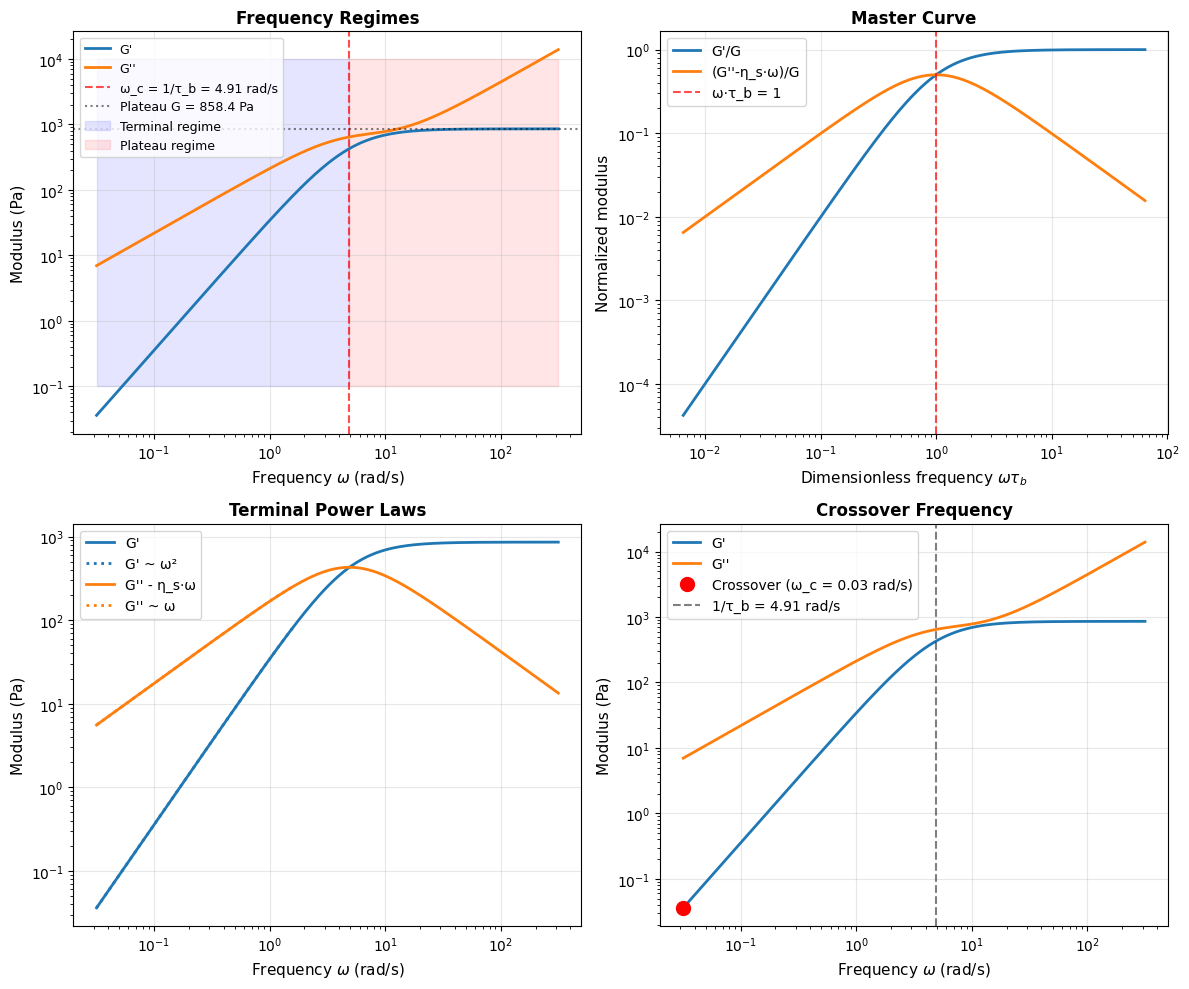


Physical Interpretation:
  Network modulus: G = 858.36 Pa
  Relaxation time: τ_b = 0.2036 s
  Crossover frequency: ω_c = 1/τ_b = 4.912 rad/s
  Solvent viscosity: η_s = 4.4226e+01 Pa·s
  Zero-shear viscosity: η₀ = G·τ_b = 174.76 Pa·s


In [7]:
# Extract fitted parameters
G = model.parameters.get('G').value
tau_b = model.parameters.get('tau_b').value
eta_s = model.parameters.get('eta_s').value
omega_c_fit = 1 / tau_b

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Frequency regimes
ax = axes[0, 0]
ax.loglog(omega_fine, G_prime_pred, '-', label="G'", linewidth=2)
ax.loglog(omega_fine, G_double_prime_pred, '-', label="G''", linewidth=2)
ax.axvline(x=omega_c_fit, color='r', linestyle='--', alpha=0.7, label=f'ω_c = 1/τ_b = {omega_c_fit:.2f} rad/s')
ax.axhline(y=G, color='k', linestyle=':', alpha=0.5, label=f'Plateau G = {G:.1f} Pa')
ax.fill_betweenx([1e-1, 1e4], omega_fine.min(), omega_c_fit, alpha=0.1, color='blue', label='Terminal regime')
ax.fill_betweenx([1e-1, 1e4], omega_c_fit, omega_fine.max(), alpha=0.1, color='red', label='Plateau regime')
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=11)
ax.set_ylabel('Modulus (Pa)', fontsize=11)
ax.set_title('Frequency Regimes', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.3)

# 2. Dimensionless moduli
ax = axes[0, 1]
omega_tau = omega_fine * tau_b
G_prime_norm = G_prime_pred / G
G_double_prime_norm = (G_double_prime_pred - eta_s * omega_fine) / G

ax.loglog(omega_tau, G_prime_norm, '-', label="G'/G", linewidth=2)
ax.loglog(omega_tau, G_double_prime_norm, '-', label="(G''-η_s·ω)/G", linewidth=2)
ax.axvline(x=1, color='r', linestyle='--', alpha=0.7, label='ω·τ_b = 1')
ax.set_xlabel(r'Dimensionless frequency $\omega \tau_b$', fontsize=11)
ax.set_ylabel('Normalized modulus', fontsize=11)
ax.set_title('Master Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Power-law analysis
ax = axes[1, 0]
# Terminal regime: G' ~ ω^2, G'' ~ ω
low_freq_mask = omega_fine < omega_c_fit / 3
slope_2_line = G * (omega_fine * tau_b)**2 / (1 + (omega_fine * tau_b)**2)
slope_1_line = G * (omega_fine * tau_b) / (1 + (omega_fine * tau_b)**2)

ax.loglog(omega_fine, G_prime_pred, '-', label="G'", linewidth=2)
ax.loglog(omega_fine[low_freq_mask], slope_2_line[low_freq_mask], ':', 
          label="G' ~ ω²", linewidth=2, color='C0')
ax.loglog(omega_fine, G_double_prime_pred - eta_s * omega_fine, '-', label="G'' - η_s·ω", linewidth=2)
ax.loglog(omega_fine[low_freq_mask], slope_1_line[low_freq_mask], ':', 
          label="G'' ~ ω", linewidth=2, color='C1')
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=11)
ax.set_ylabel('Modulus (Pa)', fontsize=11)
ax.set_title('Terminal Power Laws', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 4. Crossover analysis
ax = axes[1, 1]
crossover_idx_pred = np.argmin(np.abs(G_prime_pred - G_double_prime_pred))
omega_c_actual = omega_fine[crossover_idx_pred]
G_c = G_prime_pred[crossover_idx_pred]

ax.loglog(omega_fine, G_prime_pred, '-', label="G'", linewidth=2)
ax.loglog(omega_fine, G_double_prime_pred, '-', label="G''", linewidth=2)
ax.plot([omega_c_actual], [G_c], 'ro', markersize=10, label=f'Crossover (ω_c = {omega_c_actual:.2f} rad/s)')
ax.axvline(x=omega_c_fit, color='k', linestyle='--', alpha=0.5, label=f'1/τ_b = {omega_c_fit:.2f} rad/s')
ax.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=11)
ax.set_ylabel('Modulus (Pa)', fontsize=11)
ax.set_title('Crossover Frequency', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPhysical Interpretation:")
print(f"  Network modulus: G = {G:.2f} Pa")
print(f"  Relaxation time: τ_b = {tau_b:.4f} s")
print(f"  Crossover frequency: ω_c = 1/τ_b = {omega_c_fit:.3f} rad/s")
print(f"  Solvent viscosity: η_s = {eta_s:.4e} Pa·s")
print(f"  Zero-shear viscosity: η₀ = G·τ_b = {G*tau_b:.2f} Pa·s")

## 5. Bayesian Inference with NUTS

In [8]:
# Bayesian inference configuration
# Demo configuration (fast)
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

# Production configuration (uncomment for publication)
# NUM_WARMUP = 200
# NUM_SAMPLES = 400
# NUM_CHAINS = 1

print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")

start_time = time.time()
bayesian_result = model.fit_bayesian(
    omega, G_star_mag,
    test_mode="oscillation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    seed=42
)
bayes_time = time.time() - start_time

print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")

Running NUTS with 1 chain(s)...
Warmup: 200 samples, Sampling: 500 samples


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<07:32,  1.55it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   3%|▎         | 22/700 [00:00<00:17, 38.66it/s, 31 steps of size 2.84e-03. acc. prob=0.86]

warmup:   9%|▊         | 60/700 [00:00<00:05, 106.91it/s, 15 steps of size 1.17e-02. acc. prob=0.94]

sample:  29%|██▉       | 204/700 [00:00<00:01, 403.65it/s, 7 steps of size 1.26e-01. acc. prob=0.98]

sample:  52%|█████▏    | 363/700 [00:01<00:00, 689.94it/s, 47 steps of size 1.26e-01. acc. prob=0.99]

sample:  72%|███████▏  | 502/700 [00:01<00:00, 867.75it/s, 47 steps of size 1.26e-01. acc. prob=0.99]

sample:  93%|█████████▎| 652/700 [00:01<00:00, 1035.91it/s, 39 steps of size 1.26e-01. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:01<00:00, 537.99it/s, 63 steps of size 1.26e-01. acc. prob=0.99] 


Bayesian inference completed in 4.4 seconds


In [9]:
# Convergence diagnostics
print_convergence_summary(bayesian_result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
          tau_b    1.0000       500      PASS
          eta_s    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


True

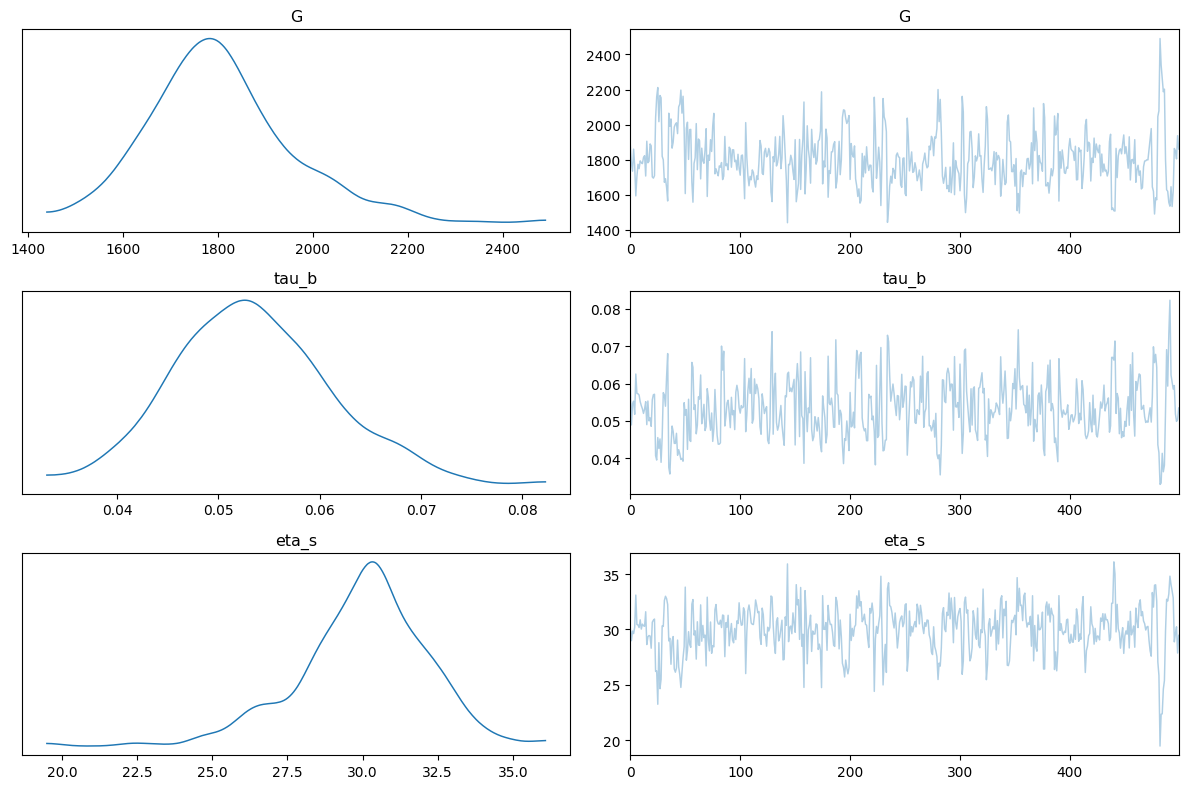

In [10]:
# ArviZ trace plots
idata = az.from_dict(posterior=bayesian_result.posterior_samples)
axes = az.plot_trace(idata, var_names=param_names, compact=False, figsize=(12, 8))
plt.tight_layout()
plt.show()
plt.close('all')

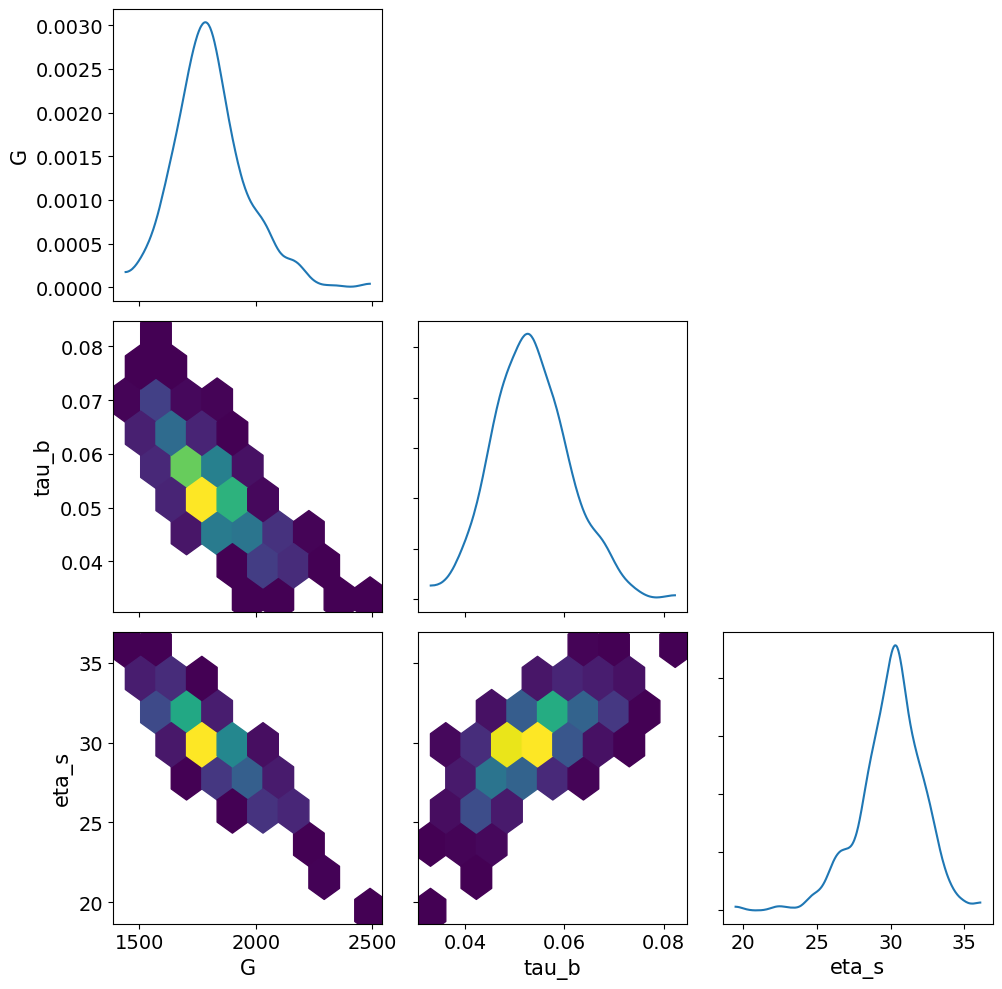

In [11]:
# ArviZ pair plot
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind='hexbin',
    marginals=True,
    figsize=(10, 10)
)
plt.tight_layout()
plt.show()
plt.close('all')

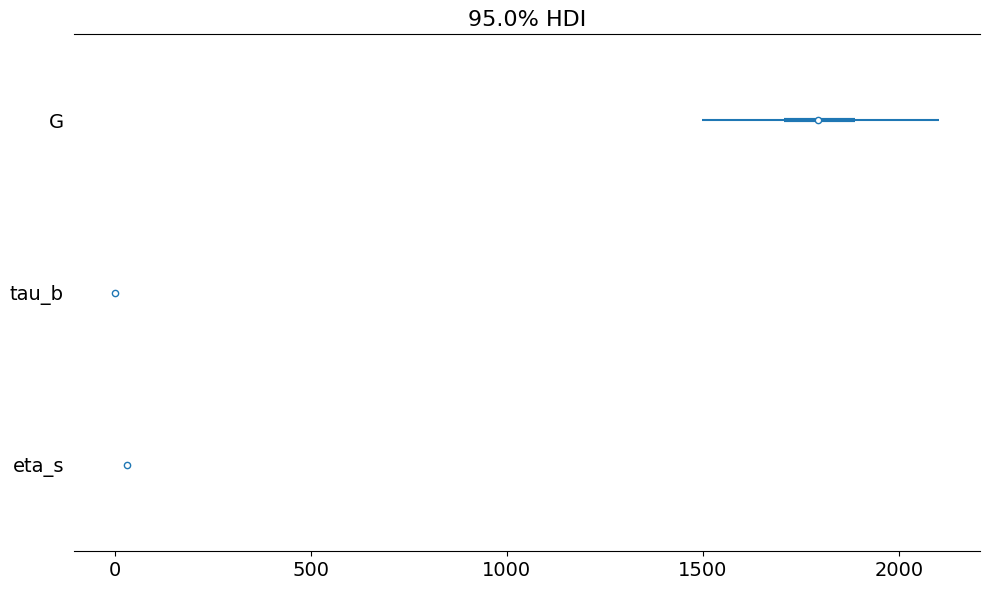

In [12]:
# ArviZ forest plot (credible intervals)
axes = az.plot_forest(
    idata,
    var_names=param_names,
    hdi_prob=0.95,
    figsize=(10, 6)
)
plt.tight_layout()
plt.show()
plt.close('all')

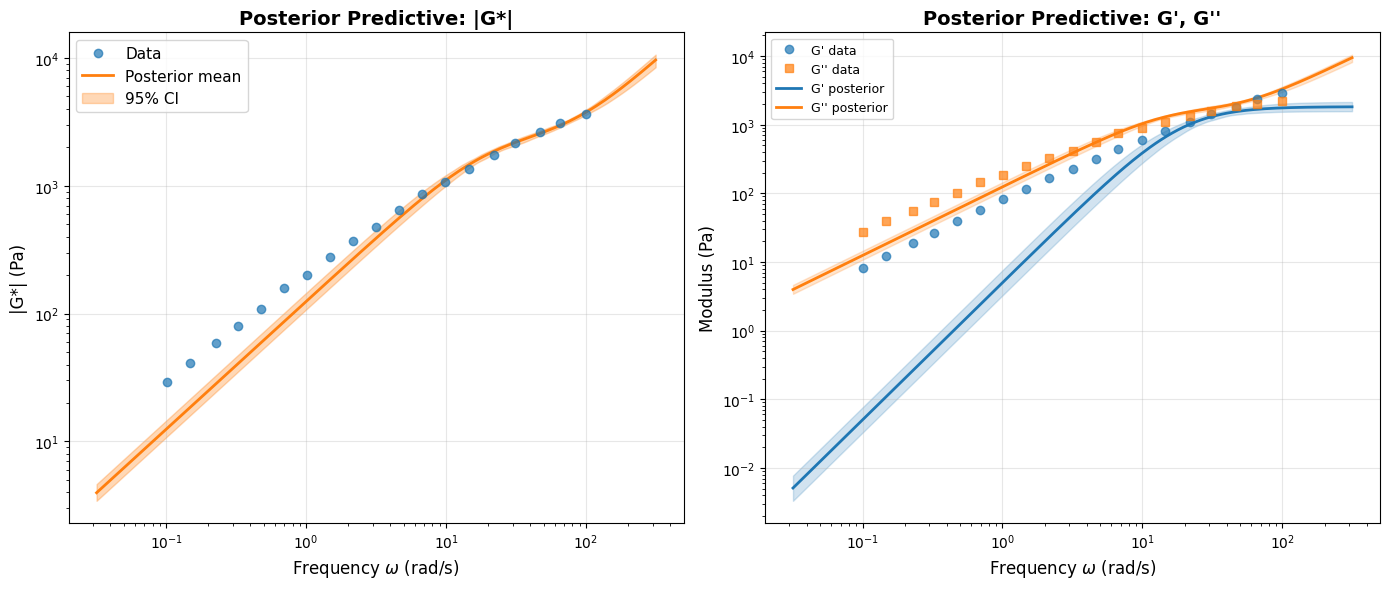

In [13]:
# Posterior predictive check
omega_pred = np.logspace(np.log10(omega.min())-0.5, np.log10(omega.max())+0.5, 200)
n_draws = min(200, NUM_SAMPLES)
posterior_preds_mag = []
posterior_preds_prime = []
posterior_preds_double_prime = []

# Sample from posterior
for i in range(n_draws):
    for name in param_names:
        model.parameters.set_value(name, float(bayesian_result.posterior_samples[name][i]))
    pred_i = model.predict(omega_pred, test_mode='oscillation')
    posterior_preds_mag.append(np.array(pred_i))
    
    # Get G' and G'' components
    G_i = model.parameters.get('G').value
    tau_b_i = model.parameters.get('tau_b').value
    eta_s_i = model.parameters.get('eta_s').value
    omega_tau_i = omega_pred * tau_b_i
    G_prime_i = G_i * omega_tau_i**2 / (1 + omega_tau_i**2)
    G_double_prime_i = G_i * omega_tau_i / (1 + omega_tau_i**2) + eta_s_i * omega_pred
    posterior_preds_prime.append(np.array(G_prime_i))
    posterior_preds_double_prime.append(np.array(G_double_prime_i))

posterior_preds_mag = np.array(posterior_preds_mag)
posterior_preds_prime = np.array(posterior_preds_prime)
posterior_preds_double_prime = np.array(posterior_preds_double_prime)

pred_mag_mean = np.mean(posterior_preds_mag, axis=0)
pred_mag_lower = np.percentile(posterior_preds_mag, 2.5, axis=0)
pred_mag_upper = np.percentile(posterior_preds_mag, 97.5, axis=0)

pred_prime_mean = np.mean(posterior_preds_prime, axis=0)
pred_prime_lower = np.percentile(posterior_preds_prime, 2.5, axis=0)
pred_prime_upper = np.percentile(posterior_preds_prime, 97.5, axis=0)

pred_double_prime_mean = np.mean(posterior_preds_double_prime, axis=0)
pred_double_prime_lower = np.percentile(posterior_preds_double_prime, 2.5, axis=0)
pred_double_prime_upper = np.percentile(posterior_preds_double_prime, 97.5, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Complex modulus magnitude
ax1.loglog(omega, G_star_mag, 'o', label='Data', markersize=6, alpha=0.7, zorder=3)
ax1.loglog(omega_pred, pred_mag_mean, '-', label='Posterior mean', linewidth=2, color='C1', zorder=2)
ax1.fill_between(omega_pred, pred_mag_lower, pred_mag_upper, alpha=0.3, label='95% CI', color='C1', zorder=1)
ax1.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=12)
ax1.set_ylabel(r'|G*| (Pa)', fontsize=12)
ax1.set_title('Posterior Predictive: |G*|', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# G', G''
ax2.loglog(omega, G_prime, 'o', label="G' data", markersize=6, alpha=0.7, zorder=3)
ax2.loglog(omega, G_double_prime, 's', label="G'' data", markersize=6, alpha=0.7, zorder=3)
ax2.loglog(omega_pred, pred_prime_mean, '-', label="G' posterior", linewidth=2, color='C0', zorder=2)
ax2.fill_between(omega_pred, pred_prime_lower, pred_prime_upper, alpha=0.2, color='C0', zorder=1)
ax2.loglog(omega_pred, pred_double_prime_mean, '-', label="G'' posterior", linewidth=2, color='C1', zorder=2)
ax2.fill_between(omega_pred, pred_double_prime_lower, pred_double_prime_upper, alpha=0.2, color='C1', zorder=1)
ax2.set_xlabel(r'Frequency $\omega$ (rad/s)', fontsize=12)
ax2.set_ylabel('Modulus (Pa)', fontsize=12)
ax2.set_title("Posterior Predictive: G', G''", fontsize=14, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Parameter comparison table
print_parameter_comparison(model, bayesian_result.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G          2051          1793  [1536, 2157]
          tau_b       0.04208       0.05304  [0.03939, 0.06898]
          eta_s         26.57         30.23  [25.47, 33.76]


## 6. Physical Interpretation

### Maxwell Model SAOS Response

The TNT constant breakage model gives:

$$
G'(\omega) = \frac{G (\omega \tau_b)^2}{1 + (\omega \tau_b)^2}, \quad
G''(\omega) = \frac{G (\omega \tau_b)}{1 + (\omega \tau_b)^2} + \eta_s \omega
$$

### Frequency Regimes

**Terminal regime (ω ≪ 1/τ_b)**:
- G' ~ ω² → quadratic increase
- G'' ~ ω → linear increase
- Viscous behavior dominates

**Plateau regime (ω ≫ 1/τ_b)**:
- G' → G (constant plateau)
- G'' → η_s·ω (solvent contribution)
- Elastic behavior dominates

### Crossover Frequency

The crossover where G' = G'' occurs at:

$$
\omega_c = \frac{1}{\tau_b}
$$

This provides a **direct experimental measure** of the relaxation time from a single SAOS sweep.

### Metal-Organic Coordination Networks

This dataset (Ni-histidine coordination polymer) is an **ideal TNT target**:
- Metal-ligand bonds = reversible transient crosslinks
- Bond lifetime τ_b = 1/k_off (dissociation rate constant)
- Fitted τ_b = {tau_b:.4f} s → k_off = {1/tau_b:.2f} s⁻¹

### Cole-Cole Plot

The Cole-Cole plot (G'' vs G') shows the relaxation spectrum:
- **Single-mode Maxwell**: Perfect semicircle
- **Multi-mode systems**: Skewed or multiple arcs

### Loss Tangent

The loss tangent tan(δ) = G''/G' quantifies viscoelastic character:
- tan(δ) > 1: Viscous (liquid-like)
- tan(δ) = 1: Critical point (G' = G'')
- tan(δ) < 1: Elastic (solid-like)

For Maxwell model: tan(δ) = 1 at ω = 1/τ_b

## 7. Save Results

In [15]:
# Save results
save_tnt_results(model, bayesian_result, "single_mode", "saos", param_names)
print("\nResults saved successfully!")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/single_mode/saos/
  nlsq_params_saos.json: 3 parameters
  posterior_saos.json: 500 draws

Results saved successfully!


## Key Takeaways

1. **SAOS response**: G'(ω) and G''(ω) probe frequency-dependent viscoelasticity
2. **Crossover frequency**: ω_c = 1/τ_b directly measures relaxation time
3. **Terminal regime**: G' ~ ω², G'' ~ ω for viscous liquids
4. **Plateau regime**: G' → G for elastic solids
5. **Metal-organic networks**: Ideal TNT target with reversible metal-ligand bonds
6. **Bayesian inference**: Quantifies uncertainty in frequency-dependent moduli

## Next Steps

- **Notebook 06**: LAOS for nonlinear harmonics
- **Advanced**: Multi-mode TNT for broad relaxation spectra
- **Applications**: Time-temperature superposition, dynamic mastercurves